In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# read file
data = pd.read_csv('duplicates/thirtyk.tsv', sep='\t', header=None, names=['text'])

data.info()
data.head()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 29994 entries, 1 to 30000
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    29994 non-null  object
dtypes: object(1)
memory usage: 468.7+ KB


,text
1,EVERYONE THAT HAS EXPERIENCED SUCCESS HAS HAD ...
2,WASHINGTON (AFP) - THE UNITED STATES' FAILURE ...
3,CORRECTING AND REPLACING BLUE PRISM IDENTIFIED...
4,PRWEB THE NEXT TAX-FILING SEASON MAY SEEM A LO...
5,WE DONT WANT LARGE NUMBER OF MUSLIMS IN OUR CO...


In [12]:
import hashlib

# use MD5
def md5_hash(text):
    return hashlib.md5(text.encode()).hexdigest()

# get hash
data['hash'] = data['text'].apply(md5_hash)

# detect duplicate
duplicate_docs = data[data.duplicated('hash')]
num_duplicates = len(duplicate_docs)

print(f"Number of duplicate documents: {num_duplicates}")


Number of duplicate documents: 3278


* This hash step I used MD5 Hash to detect the "exactly same" documents. And the result indicate there are at least 3278 same docs. 
* About 10.93% of docs are same, this means we are supposed to use larger bit array. Because the same rate seems to be a little high.
* However, in LSH, this would not affect a lot, since LSH will not make significant influence to similarity detection.

/Users/a123/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(


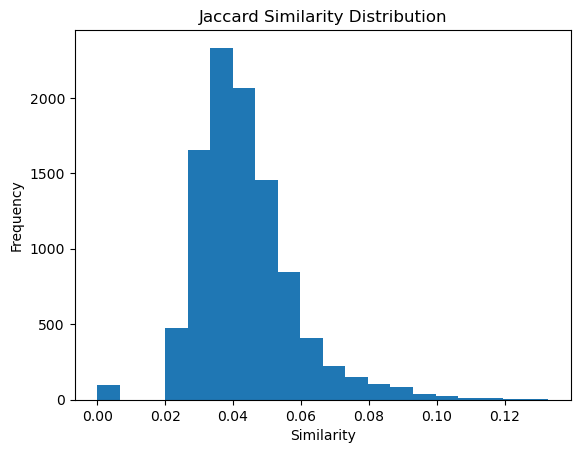

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import jaccard_score
import numpy as np

# 3-gram shingles
vectorizer = CountVectorizer(ngram_range=(3, 3), analyzer='char', stop_words='english')
shingles_matrix = vectorizer.fit_transform(data['text'])

# top 100 jaccard similarity
num_docs = 100 
similarity_matrix = np.zeros((num_docs, num_docs))

for i in range(num_docs):
    for j in range(i+1, num_docs):
        similarity_matrix[i, j] = jaccard_score(
            shingles_matrix[i].toarray()[0], 
            shingles_matrix[j].toarray()[0], 
            average='macro'
        )
        similarity_matrix[j, i] = similarity_matrix[i, j]

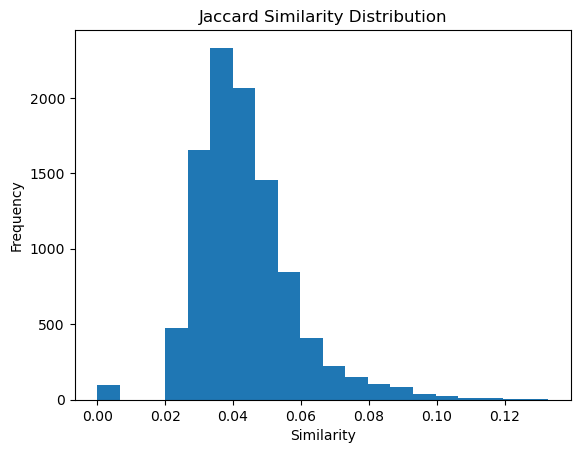

In [30]:
plt.hist(similarity_matrix.flatten(), bins=20)
plt.title('Jaccard Similarity Distribution')
plt.xlabel('Similarity')
plt.ylabel('Frequency')
plt.savefig('Jaccard Similarity Distribution.png')
plt.show()

* According to this graph, we know that the similarity is quite low at about 0.02 ~ 0.05, and that indicates the similar documents are less.
* For LSH, this means we can use larger row number "r", in order to decrease unecessary similarity match. 

In [15]:
import math

n = len(data)  
p = 0.01 # expected false rate

m = -(n * math.log(p)) / (math.log(2) ** 2)
k = (m / n) * math.log(2)

print(f"Recommended Bloom Filter size (m): {math.ceil(m)}")
print(f"Recommended number of hash functions (k): {math.ceil(k)}")


Recommended Bloom Filter size (m): 287495
Recommended number of hash functions (k): 7


- This means we need to have at least 287495 bit array to store the data so we can keep the false positive rate at 1%. If the "m(filter size)" get bigger, the bloom filter can contain more data with lower mistake rate p.
- Since the recommended k is 7, this indicate every time we insert a document, this bloom filter will calculate positino via these 7 hash function, and set the value as 1.


## Test for real duplicate and false positive rate analysis
In this step, I tried random text to get false positive rate to see if I could make it get closed to 1%.

In [17]:
import random
import hashlib

# simple example for bloom filter
class BloomFilter:
    def __init__(self, size, hash_count):
        self.size = size
        self.hash_count = hash_count
        self.bit_array = [0] * size

    def add(self, string):
        for seed in range(self.hash_count):
            result = hashlib.md5((string + str(seed)).encode()).hexdigest()
            index = int(result, 16) % self.size
            self.bit_array[index] = 1

    def check(self, string):
        for seed in range(self.hash_count):
            result = hashlib.md5((string + str(seed)).encode()).hexdigest()
            index = int(result, 16) % self.size
            if self.bit_array[index] == 0:
                return False
        return True
# initialize
bloom = BloomFilter(size=287495, hash_count=7)

# add text to bloom filter
for text in data['text']:
    bloom.add(text)

# false positive rate test with a random text sequence
num_tests = 10000
false_positives = 0

for _ in range(num_tests):
    random_text = ''.join(random.choices('abcdefghijklmnopqrstuvwxyz0123456789', k=20))
    if bloom.check(random_text):
        false_positives += 1

# get real actual positive rate (no false negative)
actual_false_positive_rate = false_positives / num_tests
print(f"Actual False Positive Rate: {actual_false_positive_rate:.5f}")


Actual False Positive Rate: 0.00580


According to the result, the actual false rate is 0.58% much lower than 1%, which means the bloom filer could be quite useful here.
The parameter (bloom filter size m=287495) and k=7 (function number) could be good enough with less hash conflict, and that's why we have lower false rate.

## Threshold for document similarity
In LSH, I want to set the threshold value based on known  Jaccard similarity distribution. Therefore, we will know that how to avoid the higher false positive rate.
- Here we set different threshold value(0.1, 0.2, 0.3) to see the variation

In [20]:

similarity_threshold = 0.1  # 0.1
similar_pairs = []

for i in range(num_docs):
    for j in range(i+1, num_docs):
        if similarity_matrix[i, j] >= similarity_threshold:
            similar_pairs.append((i, j))

print(f"Number of similar document pairs (threshold {similarity_threshold}): {len(similar_pairs)}")


similarity_threshold = 0.2  # 0.2
similar_pairs = []

for i in range(num_docs):
    for j in range(i+1, num_docs):
        if similarity_matrix[i, j] >= similarity_threshold:
            similar_pairs.append((i, j))

print(f"Number of similar document pairs (threshold {similarity_threshold}): {len(similar_pairs)}")


similarity_threshold = 0.3  # 0.3
similar_pairs = []

for i in range(num_docs):
    for j in range(i+1, num_docs):
        if similarity_matrix[i, j] >= similarity_threshold:
            similar_pairs.append((i, j))

print(f"Number of similar document pairs (threshold {similarity_threshold}): {len(similar_pairs)}")


Number of similar document pairs (threshold 0.1): 30
Number of similar document pairs (threshold 0.2): 0
Number of similar document pairs (threshold 0.3): 0


- According to this, now we know that there are about 30 pairs similar documents here with at least 10% of contents (which means Jaccard similarity is larger than 0.1). And those pairs could be considered as "similar" docs.

- However, when we look at threshold as 0.2 and 0.3, pairs equal to 0, this simply means we can only detect similar stuff with part of content, and that indicate they do not have too many similar periods. For the r and b value in bloom filter, we can set larger b and smaller r to detect the lower similarity pairs.

- If we increased b like b=20, this means we increased the matching sensitivity so we could detect them even with potential low similarity.

## Minhash Optimization

Except previous discussion that we made, now we could pay more attention on n-gram length. For exmaple, we could try (4-gram, 5-gram).

In [31]:
# 4-gram shingles
vectorizer = CountVectorizer(ngram_range=(4, 4), analyzer='char')
shingles_matrix_4gram = vectorizer.fit_transform(data['text'])

# calculate similarity
similarity_matrix_4gram = np.zeros((num_docs, num_docs))

for i in range(num_docs):
    for j in range(i+1, num_docs):
        similarity_matrix_4gram[i, j] = jaccard_score(
            shingles_matrix_4gram[i].toarray()[0], 
            shingles_matrix_4gram[j].toarray()[0], 
            average='macro'
        )
        similarity_matrix_4gram[j, i] = similarity_matrix_4gram[i, j]

# get similarity distribution
plt.hist(similarity_matrix_4gram.flatten(), bins=20)
plt.title('4-gram Jaccard Similarity Distribution')
plt.xlabel('Similarity')
plt.ylabel('Frequency')
plt.savefig('4-gram Jaccard Similarity Distribution.png')
plt.show()




Based on the result of 4-gram, we can make conclusions:
- Most of documents have similarities at around 0.05, this means 4-gram make them get more dissimilar.

- Compared with 3-gram, we found this the longer n-gram we have, the less similar they will be. And we need more consecutive detection to prove the similar pairs.

- We can use lower r and larger b to make sure we can detect more.